In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
from scipy.interpolate import griddata
from datetime import datetime, timedelta
import gsw
import datetime
import cartopy.crs as ccrs
from pathlib import Path
import cmasher as cmr
import matplotlib.colors as mcolors
plt.rcParams['font.size']=14

In [2]:
path_in_ctd=Path('../../observation/SO_CHIC_CTD/')
ds_ctd=xr.open_mfdataset(list(path_in_ctd.glob(f'SOCHIC*.nc')))#,combine="nested")
ds_ctd.coords['depth']=-1*(gsw.z_from_p(ds_ctd.pressure,ds_ctd.Latitude))
ds_ctd['pottemp']=gsw.pt0_from_t(gsw.SA_from_SP(ds_ctd.PSAL,ds_ctd.pressure,ds_ctd.Longitude,ds_ctd.Latitude),ds_ctd.TEMP,ds_ctd.pressure)
ds_ctd
# interpolate data onto 1m bins and create a new dataset with it
dim_3D = ("station","depth")
dim_2D = ("station")
z_int=np.arange(0,6000,1)
temi=np.zeros([len(ds_ctd.station),len(z_int)])
sali=np.zeros([len(ds_ctd.station),len(z_int)])
for i in range(0,len(ds_ctd.station)):
    temi[i,:] = np.interp(z_int,ds_ctd.depth.isel(station=i),ds_ctd.pottemp.isel(station=i))
    sali[i,:] = np.interp(z_int,ds_ctd.depth.isel(station=i),ds_ctd.PSAL.isel(station=i))
ds_grid= xr.Dataset(
        data_vars=dict(T_grided=(dim_3D, temi), S_grided=(dim_3D, sali),lat=(dim_2D,ds_ctd.Latitude),lon=(dim_2D,ds_ctd.Longitude)),
                   coords=dict(
            station= (["station"],ds_ctd.station),
            depth = (["depth"],z_int)
            )
        )



In [3]:
# extract the 2 northern transects from the CTD dataset
ds_s1=ds_grid.isel(station=slice(3,16)).sortby(ds_grid.station,ascending=False)
ds_s2=ds_grid.isel(station=slice(16,33)).sortby(ds_grid.station,ascending=False)


In [4]:
ds13=xr.open_dataset('../../observation/en4_2013_5mbins.nc')
ds13=ds13.isel(N_PROF=slice(2,23))

In [5]:
ds_s1.coords['lat']=ds_s1.lat
ds_s2.coords['lat']=ds_s2.lat

ds13.coords['lat']=ds13.lat
# its necessary to sort these transcects, because there is a back and forth in the latitude
ds_s2_ori=ds_s2
ds_s2=ds_s2_ori.sortby(ds_s2_ori.lat)
# create a colorbar, where the warmest temperature is bright yellow
n_lev=36
col = cmr.take_cmap_colors(cmo.thermal, n_lev, return_fmt='hex')
col[-1]='#faf0e6'
colors_halo=mcolors.LinearSegmentedColormap.from_list('colormap', col)

<ipython-input-6-2c8a338bf26d>:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


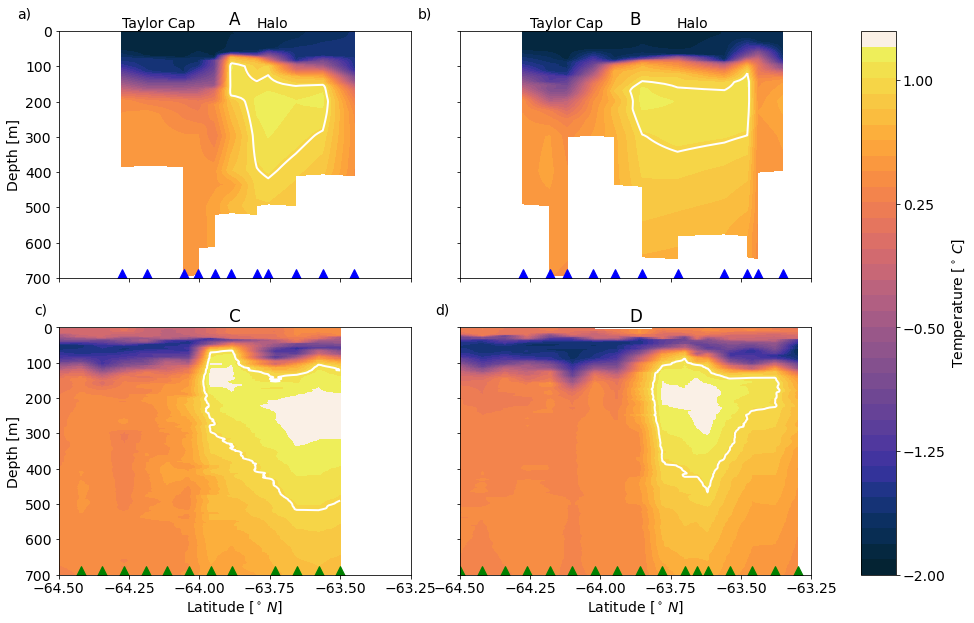

In [6]:
# Figure 2 in the manuscript
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(15,10)) 
gs = GridSpec(2, 3, width_ratios=[1,1,0.1],wspace=.2)#,wspace=0.3)

t1_mean12 = fig.add_subplot(gs[0,0])
t2_mean12 = fig.add_subplot(gs[0,1],yticklabels=[])
t3_mean12 = fig.add_subplot(gs[1,0])
t4_mean12 = fig.add_subplot(gs[1,1],yticklabels=[])
c_ax = fig.add_subplot(gs[:2, 2])

#2013
ax=t1_mean12
ds13.T_grided.isel(N_PROF=slice(0,11)).plot.contourf(x="lat",y="depth",ax=ax,cmap=colors_halo,vmin=-2,vmax=1.3,levels=n_lev,add_colorbar=False)
ds13.T_grided.isel(N_PROF=slice(0,11)).plot.contour(x="lat",y="depth",ax=ax,levels=[1.0],colors='w',linestyles='-',linewidths=2)
for i in range(0,11):
    ax.plot(ds13.lat[i],690,marker='^',color='b',markersize=10)
ax.set_xlim(-64.5,-63.3)
ax.set_ylim(0,700)
ax.invert_yaxis()
ax.set_title('A')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.text(ds13.lat[10],-10, 'Taylor Cap')
ax.text(ds13.lat[4],-10, 'Halo')
ax.set_ylabel('Depth [m]')
ax.set_xticks(ticks=np.arange(-64.5,-63.0,.25))
plt.text(-0.1, 1.07, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

#2013
ax=t2_mean12
ds13.T_grided.isel(N_PROF=slice(10,None,None)).plot.contourf(x="lat",y="depth",ax=ax,cmap=colors_halo,vmin=-2,vmax=1.3,levels=n_lev,add_colorbar=False)
ds13.T_grided.isel(N_PROF=slice(10,None,None)).plot.contour(x="lat",y="depth",ax=ax,levels=[1.0],colors='w',linestyles='-',linewidths=2)
for i in range(10,len(ds13.lat)):
    ax.plot(ds13.lat[i],690,marker='^',color='b',markersize=10)
ax.set_ylim(0,700)
ax.set_xlim(-64.5,-63.3)
ax.invert_yaxis()
ax.set_title('B')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_xticks(ticks=np.arange(-64.5,-63.0,.25))
ax.text(-64.25,-10, 'Taylor Cap')
ax.text(ds_s1.lat[3],-10, 'Halo')
plt.text(-0.1, 1.07, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

#2022
ax=t3_mean12
c1=ds_s1.T_grided.plot.contourf(x="lat",y="depth",ax=ax,cmap=colors_halo,vmin=-2,vmax=1.3,levels=n_lev,add_colorbar=False)
ds_s1.T_grided.plot.contour(x="lat",y="depth",ax=ax,levels=[1.0],colors='w',linestyles='-',linewidths=2)
for i in range(0,len(ds_s1.lat)):
    ax.plot(ds_s1.lat[i],690,marker='^',color='g',markersize=10)
ax.set_ylim(0,700)
ax.set_xlim(-64.5,-63.3)
ax.invert_yaxis()
ax.set_title('C')
ax.set_xlabel('Latitude [$^\circ\,N$]')
ax.set_xticks(ticks=np.arange(-64.5,-63.0,.25))
ax.set_ylabel('Depth [m]')
plt.text(-0.05, 1.07, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

#2022
ax=t4_mean12
c1=ds_s2.T_grided.plot.contourf(x="lat",y="depth",ax=ax,cmap=colors_halo,vmin=-2,vmax=1.3,levels=n_lev,add_colorbar=False)
ds_s2.T_grided.plot.contour(x="lat",y="depth",ax=ax,levels=[1.0],colors='w',linestyles='-',linewidths=2)
for i in range(0,len(ds_s2.lat)):
    ax.plot(ds_s2.lat[i],690,marker='^',color='g',markersize=10)
ax.set_ylim(0,700)
ax.set_xlim(-64.5,-63.3)
ax.invert_yaxis()
ax.set_title('D')
ax.set_xlabel('Latitude [$^\circ\,N$]')
ax.set_ylabel('')
ax.set_xticks(ticks=np.arange(-64.5,-63.0,.25))
plt.text(-0.05, 1.07, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
cbar=plt.colorbar(c1,cax=c_ax, label='Temperature [$^\circ\,C$]',ticks=np.linspace(-2,1,5))#,orientation="horizontal",ticks=np.linspace(-.1,.1,3))
plt.tight_layout()
#plt.savefig('./T_sections_2013_2022.jpg',dpi=300)
